<a href="https://colab.research.google.com/github/eric-nguyen13/assignment4/blob/main/assignment4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment #4: Linear Models and Decision Trees
## Foundations of Machine Learning
## Eric Nguyen - wvu9cs
## Do Q1 and one other question.
### Advice: Reuse your code and code from lectures, package routine tasks into functions, make plans about how you'll carry out the analysis before jumping into writing code, and work as efficiently as possible

In [1]:
# Load the data from GitHub
! git clone https://www.github.com/DS3001/assignment4

fatal: destination path 'assignment4' already exists and is not an empty directory.


**Q1.** This question is a case study for linear models and decision trees. The data are about car prices. In particular, they include:

  - `Price`, `Color`, `Seating_Capacity`
  - `Body_Type`: crossover, hatchback, muv, sedan, suv
  - `Make`, `Make_Year`: The brand of car and year produced
  - `Mileage_Run`: The number of miles on the odometer
  - `Fuel_Type`: Diesel or gasoline/petrol
  - `Transmission`, `Transmission_Type`:  speeds and automatic/manual

  1. Load `cars_hw.csv`. These data were really dirty, and I've already cleaned them a significant amount in terms of missing values and other issues, but some issues remain (e.g. outliers, badly scaled variables that require a log or arcsinh transformation). Clean the data however you think is most appropriate.
  2. Summarize the `Price` variable and create a kernel density plot. Use `.groupby()` and `.describe()` to summarize prices by brand (`Make`). Make a grouped kernel density plot by `Make`. Which car brands are the most expensive? What do prices look like in general?
  3. Split the data into an 80% training set and a 20% testing set.
  4. Let's focus on linear models. Make a model where you regress price on the numeric variables alone; what is the $R^2$ and `RMSE` on the test set? Make a second model where, for the categorical variables, make a model comprised of one-hot encoded regressors/features alone, and regress price on those variables; what is the $R^2$ and `RMSE` on the test set? Which model performs better on the test set? Make a third model that combines all the regressors from the previous two; what is the $R^2$ and `RMSE` on the test set? Does the joint model perform better or worse, and by home much?
  5. Use the `PolynomialFeatures` function from `sklearn` to expand the set of numerical variables you're using, along with the categorical variables. As you increase the degree of the expansion, how do the $R^2$ and `RMSE` change? At what point does $R^2$ go negative on the test set? For your best model with expanded features, what is the $R^2$ and `RMSE`? How does it compare to your best model from part 3?
  6. For your best model so far, determine the predicted values for the test data and plot them against the true values. Do the predicted values and true values roughly line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero? Evaluate the strengths and weaknesses of your model.
  7. Now, let's use a regression tree. Construct an appropriate matrix of regressors/features, and fit a tree to the data. Vary the maximum depth of the decision tree using the `max_depth` option (i.e. `tree.DecisionTreeRegressor(max_depth=D)`), and compute the $R^2$ and `RMSE` on the test set of a variety of depths. What depth tree gives the best results?
  8. For your best tree, determine the predicted values for the test data, and plot them against the true values. Do the predicted values and true values line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero?
  12. Which model --- linear model or classification and regression tree --- has better performance on the test set?

In [2]:
import pandas as pd
import numpy as np

# 1. Load and clean cars_hw.csv
df = pd.read_csv('./assignment4/data/cars_hw.csv')

# Drop the unecessary column
df = df.drop('Unnamed: 0', axis=1)

# Convert No_of_Owners to numerical values
ownership_mapping = {'1st': 1, '2nd': 2, '3rd': 3}
df['No_of_Owners'] = df['No_of_Owners'].map(ownership_mapping)

# Scale Price
df['Price'] = np.arcsinh(df['Price'])

# Calculate Q1 and Q3
Q1 = df['Price'].quantile(0.25)
Q3 = df['Price'].quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Find outliers to Scale Price column
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = df[(df['Price'] < lower_bound) | (df['Price'] > upper_bound)]

# Drop outliers
df = df[(df['Price'] >= lower_bound) & (df['Price'] <= upper_bound)]

# Print out Dimensions and Shape of dataframe
print("Columns Names: " + str(df.columns) + "\n")
print("Shape: " + str(df.shape) + "\n")

df.head(10)

Columns Names: Index(['Make', 'Make_Year', 'Color', 'Body_Type', 'Mileage_Run',
       'No_of_Owners', 'Seating_Capacity', 'Fuel_Type', 'Transmission',
       'Transmission_Type', 'Price'],
      dtype='object')

Shape: (974, 11)



,Make,Make_Year,Color,Body_Type,Mileage_Run,No_of_Owners,Seating_Capacity,Fuel_Type,Transmission,Transmission_Type,Price
0,Volkswagen,2017,silver,sedan,44611,1,5,diesel,7-Speed,Automatic,14.088586
1,Hyundai,2016,red,crossover,20305,1,5,petrol,5-Speed,Manual,14.125932
2,Honda,2019,white,suv,29540,2,5,petrol,5-Speed,Manual,14.276726
3,Renault,2017,bronze,hatchback,35680,1,5,petrol,5-Speed,Manual,13.626768
4,Hyundai,2017,orange,hatchback,25126,1,5,petrol,5-Speed,Manual,13.845069
5,Hyundai,2016,red,hatchback,52261,1,5,petrol,5-Speed,Manual,14.004477
6,Honda,2012,grey,hatchback,28108,2,5,petrol,5-Speed,Manual,13.356645
7,Tata,2019,grey,suv,92603,1,5,diesel,6-Speed,Automatic,14.858610
8,Hyundai,2021,blue,hatchback,16304,1,5,petrol,5-Speed,Manual,14.166167
9,Renault,2019,bronze,hatchback,26350,2,5,petrol,5-Speed,Manual,13.572164


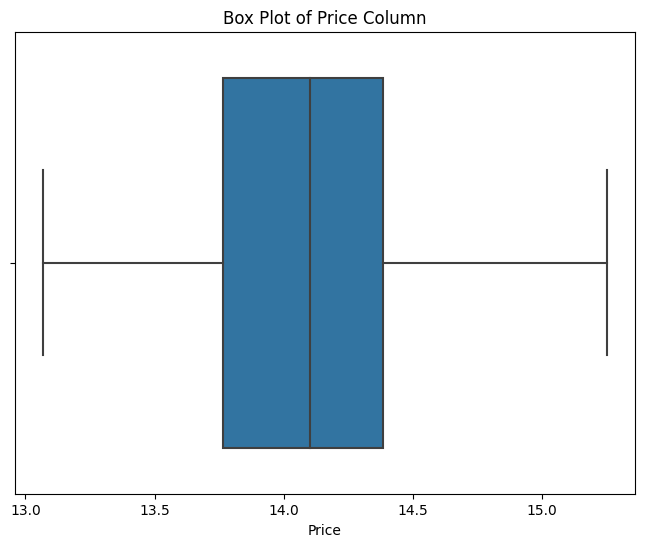

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Create a box plot to visualize outliers - No more left!
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['Price'])
plt.title('Box Plot of Price Column')
plt.show()


Summary Statistics of Price:
count    974.000000
mean      14.103958
std        0.446380
min       13.068963
25%       13.766845
50%       14.102942
75%       14.383944
max       15.250595
Name: Price, dtype: float64

Group By Describe:
               count       mean       std        min        25%        50%  \
Make                                                                         
Chevrolet        6.0  13.613042  0.480975  13.188151  13.261539  13.445433   
Datsun           3.0  13.269194  0.036311  13.232114  13.251449  13.270783   
Ford            52.0  14.161427  0.210895  13.270783  14.054527  14.162640   
Honda           73.0  14.229465  0.336972  13.356645  13.965653  14.266586   
Hyundai        305.0  14.061658  0.398781  13.114331  13.785051  14.059241   
Jeep             4.0  14.909738  0.105084  14.763300  14.876417  14.933413   
Kia              8.0  14.985324  0.076877  14.822738  14.965389  14.996253   
MG Motors       35.0  15.132199  0.066263  14.971763  15.0888

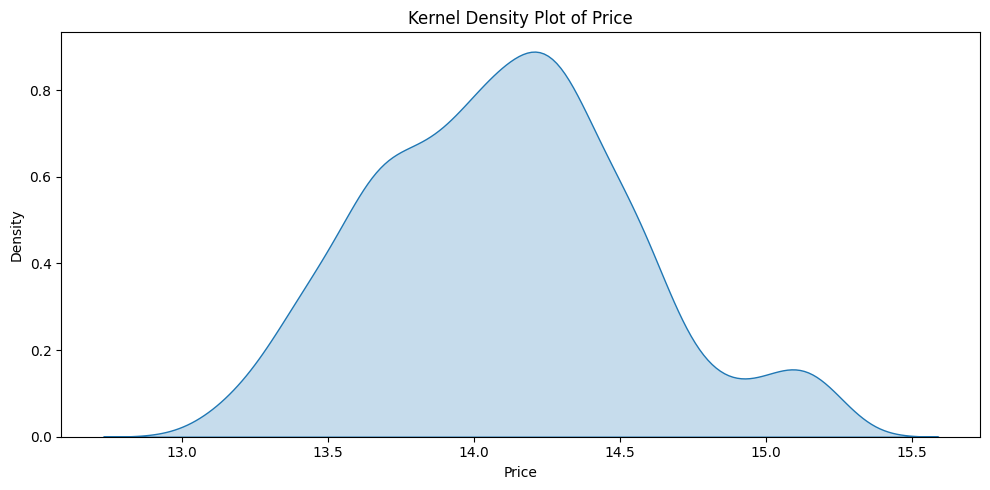

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 2. Summarize the (Scaled) Price variable and create a kernel density plot
plt.figure(figsize=(10, 5))

# Summary statistics of Price
print("Summary Statistics of Price:")
print(df['Price'].describe())
print()
print("Group By Describe:")
print(df.groupby('Make')['Price'].describe())

# Kernel density plot for Price
plt.subplot(1, 1, 1)
sns.kdeplot(df['Price'], fill=True)
plt.title('Kernel Density Plot of Price')

print()
plt.tight_layout()
plt.show()



Grouped Summary of Prices by Brand:
               count       mean       std        min        25%        50%  \
Make                                                                         
Chevrolet        6.0  13.613042  0.480975  13.188151  13.261539  13.445433   
Datsun           3.0  13.269194  0.036311  13.232114  13.251449  13.270783   
Ford            52.0  14.161427  0.210895  13.270783  14.054527  14.162640   
Honda           73.0  14.229465  0.336972  13.356645  13.965653  14.266586   
Hyundai        305.0  14.061658  0.398781  13.114331  13.785051  14.059241   
Jeep             4.0  14.909738  0.105084  14.763300  14.876417  14.933413   
Kia              8.0  14.985324  0.076877  14.822738  14.965389  14.996253   
MG Motors       35.0  15.132199  0.066263  14.971763  15.088892  15.122762   
Mahindra        18.0  14.592100  0.159906  14.280502  14.544955  14.598828   
Maruti Suzuki  293.0  13.911280  0.371409  13.068963  13.619496  13.868103   
Nissan           4.0  14.33

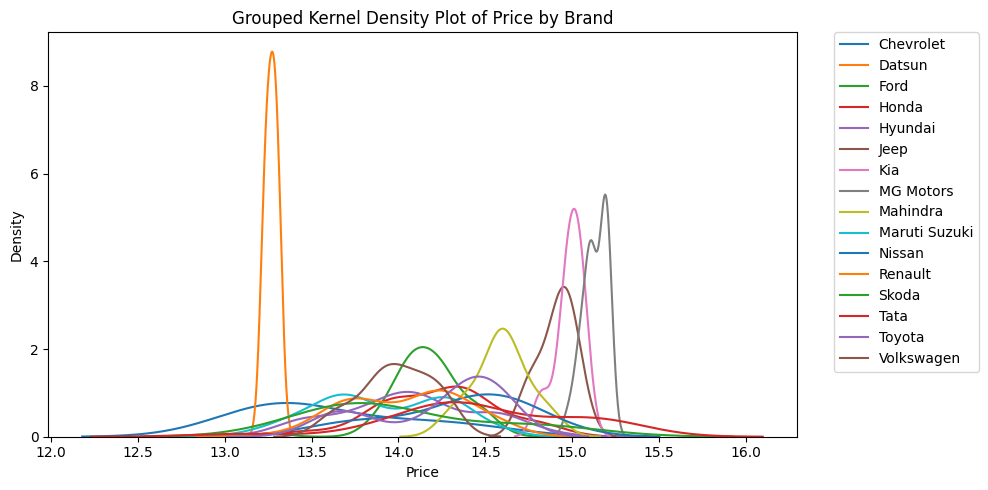

In [5]:
# 2. Grouped summary by Make
plt.figure(figsize=(10, 5))
print("\nGrouped Summary of Prices by Brand:")
print(df.groupby('Make')['Price'].describe())

# Grouped kernel density plot by Make
plt.subplot(1, 1, 1)
for make, data in df.groupby('Make'):
    sns.kdeplot(data['Price'], label=make, common_norm=False)

plt.title('Grouped Kernel Density Plot of Price by Brand')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

print()
plt.tight_layout()
plt.show()

Based on the Grouped Kernel Density Plot, the top three most expensive car brands include MG Motors, Kia, and Jeep as evidenced by the lines on the higher end of the x-axis (Price). The average (peak) of these companies are the highest of all the car brands.

In addition, the graph indicates that the general car price sits around 14.0 - 14.5. This is clearly evidenced by the many car brands whose peaks are in this range. In addiiton, the distribution is much wider in comparison to the most expensive car brands, perhaps indicating that these car brands offer a wide selection of cars at many intervals of prices.

In [6]:
# 3. Split the sample into a ~80% training and ~20% testing dataset
from sklearn.model_selection import train_test_split

X = df.drop('Price', axis=1)
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state=42)

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# 4. Make linear models

# Get the train and test sets
X_train_numerical = X_train.select_dtypes(include='number')
X_test_numerical = X_test.select_dtypes(include='number')
X_train_categorical = X_train.select_dtypes(exclude='number')
X_test_categorical = X_test.select_dtypes(exclude='number')
y = df['Price']

# Get the Numerical and Categorical variables
numerical_columns = list(X_train_numerical)
categorical_columns = list(X_train_categorical)

# One Hot Encode Categorical Variables + Fit Transform - for 4B
categorical_transformer = ColumnTransformer([("categorical", OneHotEncoder(handle_unknown='ignore'), categorical_columns)])
X_train_categorical_prepared = categorical_transformer.fit_transform(X_train_categorical)
X_test_categorical_prepared = categorical_transformer.transform(X_test_categorical)

# Impute numerical missing values with the median
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),])

# Combined numerical and categorical into one pipeline - for 4C
combined_transformer = ColumnTransformer([
        ('numerical', numeric_transformer, numerical_columns),
        ("categorical", OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ])

# Fit transform
X_train_prepared = combined_transformer.fit_transform(X_train)
X_test_prepared = combined_transformer.transform(X_test)


# 4A. Make a model where you regress on numeric variables alone
model_numeric = LinearRegression()
model_numeric.fit(X_train_numerical, y_train)
numerical_predictions = model_numeric.predict(X_test_numerical)
numerical_rmse = mean_squared_error(y_test, numerical_predictions, squared=False)
r2_numerical = model_numeric.score(X_test_numerical, y_test)
print("R^2 for Numeric Features Only:", r2_numerical)
print("RMSE for Model with Numeric Features Only:", numerical_rmse)
print()


# 4B. Make a model for categorical variables one-hot encoded features and regress price
model_categorical = LinearRegression()
model_categorical.fit(X_train_categorical_prepared, y_train)
categorical_predictions = model_categorical.predict(X_test_categorical_prepared)
categorical_rmse = mean_squared_error(y_test, categorical_predictions, squared=False)
r2_categorical = model_categorical.score(X_test_categorical_prepared, y_test)
print("R^2 for Categorical Features Only:", r2_categorical)
print("RMSE for Model with Categorical Features Only:", categorical_rmse)
print()


# 4C. Combine numeric and categorical features
model_combined = LinearRegression()
model_combined.fit(X_train_prepared, y_train)
combined_predictions = model_combined.predict(X_test_prepared)
combined_rmse = mean_squared_error(y_test, combined_predictions, squared=False)
r2_combined = model_combined.score(X_test_prepared, y_test)
print("R^2 for Combined Numeric and Categorical Features:", r2_combined)
print("RMSE for Model with Combined Features:", combined_rmse)
print()




R^2 for Numeric Features Only: 0.3665856857094715
RMSE for Model with Numeric Features Only: 0.345636989717336

R^2 for Categorical Features Only: 0.6042983061167575
RMSE for Model with Categorical Features Only: 0.27318712766600134

R^2 for Combined Numeric and Categorical Features: 0.7725822604376982
RMSE for Model with Combined Features: 0.20710398072254213



Based on the R^2 and RMSE calculations above, the model that performs better on the test set is the Categorical Model (Model 2). This is evidenced by the higher R^2 value at 0.604 in comparison to the numeric model's 0.366 R^2. Because the 0.604 R^2 is closer to 1, that indicates that it is a better fit of the regression. In addition, the RMSE for the Categorical Model is lower (0.273) indicating that it is fitted better for the test set in comparison to the numeric model's RMSE (0.345).

When introducing the Combined Model (both numerical and categorical), it was found that Model 3 performs best on the test set. With similar reasons as before, Model 3 has the highest R^2 value out of the three models at 0.772 and the lowest RMSE at 0.207.

In [8]:
from sklearn.preprocessing import PolynomialFeatures
# 5. Use Polynomial Features

degrees_to_test = range(1, 11)  # Range of polynomial degrees to test
best_r2 = -1                    # Stores degree of the best r2
negative_r2 = -1                # Stores degree where r2 becomes negative
best_degree = 0                 # Stores degree that has the best r2


for degree in degrees_to_test:
  numerical_pipeline_polynomial = Pipeline([
      ('poly', PolynomialFeatures(degree=degree, include_bias=False)),])

  # Combined numerical and categorical into one pipeline - Similar to 4C
  polynomial_transformer = ColumnTransformer([
          ('numerical', numerical_pipeline_polynomial, numerical_columns),
          ("categorical", OneHotEncoder(handle_unknown='ignore'), categorical_columns)
      ])
  X_train_prepared = polynomial_transformer.fit_transform(X_train)
  X_test_prepared = polynomial_transformer.transform(X_test)

  # Create the model
  model_polynomial = LinearRegression()
  model_polynomial.fit(X_train_prepared, y_train)
  polynomial_predictions = model_polynomial.predict(X_test_prepared)
  polynomial_rmse = mean_squared_error(y_test, polynomial_predictions, squared=False)
  r2_polynomial = model_polynomial.score(X_test_prepared, y_test)

  if r2_polynomial < 0:
    negative_r2 = degree
  if r2_polynomial > best_r2:
      best_r2 = r2_polynomial
      best_degree = degree

  print(f"Degree {degree}: R^2: {r2_polynomial}, RMSE: {polynomial_rmse}")

print(f"\nBest R^2 achieved at degree {best_degree}: {best_r2}")
print(f"R^2 went negative at degree {negative_r2}")

Degree 1: R^2: 0.7725822604376982, RMSE: 0.20710398072254213
Degree 2: R^2: 0.804051333705987, RMSE: 0.19224162690468577
Degree 3: R^2: 0.7184029105985885, RMSE: 0.23045724088185757
Degree 4: R^2: 0.4367804808349862, RMSE: 0.3259230876474441
Degree 5: R^2: -2.1148279185182224, RMSE: 0.7664667271519598
Degree 6: R^2: 0.40491191587421005, RMSE: 0.3350170455307458
Degree 7: R^2: 0.4105042288405494, RMSE: 0.33343917613475643
Degree 8: R^2: 0.22358911061847753, RMSE: 0.38266794679209815
Degree 9: R^2: 0.2571745543211512, RMSE: 0.37429985885004374
Degree 10: R^2: 0.31378542611354243, RMSE: 0.3597545090433706

Best R^2 achieved at degree 2: 0.804051333705987
R^2 went negative at degree 5


Based on the calculations above, here are the R^2 trends as the degree increases:
* Degree 1 to 2: R^2 increases from 0.7726 to 0.8041.
* Degree 2 to 3: R^2 decreases from 0.8041 to 0.7184.
* Degree 3 to 4: R^2 decreases significantly from 0.7184 to 0.4368.
* Degree 4 to 5: R^2 drops sharply and becomes negative at -2.1148.
* Degree 5 to 10: R^2 gradually increases but remains relatively low, reaching 0.3138 at degree 10.

The initial increase in R^2 suggests that adding polynomial features up to a certain degree improves the model. But after a certain point (approximately degree 2 to 3), increasing the degree causes overfitting which negatively affects the model's accuracy.

At degree 5, the R^2 becomes negative indicating that the model is overfitting as well as capturing patterns that don't generalize well to the test data. The negative R^2 perhaps suggests that the model does worse than a regular, simple model.

Based on the calculations above, here are the RMSE trends as the degree increases:
* Degree 1 to 2: RMSE decreases from 0.2071 to 0.1922.
* Degree 2 to 3: RMSE increases from 0.1922 to 0.2305.
* Degree 3 to 4: RMSE increases further to 0.3259.
* Degree 4 to 5: RMSE spikes significantly to 0.7665.
* Degree 5 to 10: RMSE gradually decreases, reaching 0.3598 at degree 10.

The RMSE trends contrast the R^2 trends as the go in the opposite direction. This is because a high R^2 value is good whereas a low RMSE value is good. It's important to consider both R^2 and RMSE values when evaluating a model's performance.

The best model was achieved at degree 2 where the R^2 value was 0.804 and the RMSE value was 0.192. In comparison to the model from part 3, this model performed better since it had a higher R^2 value and a lower RMSE value.

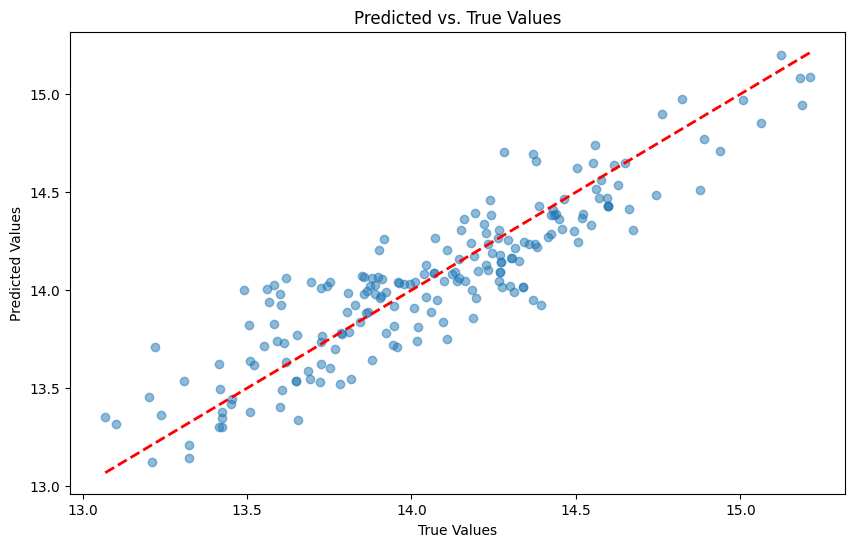

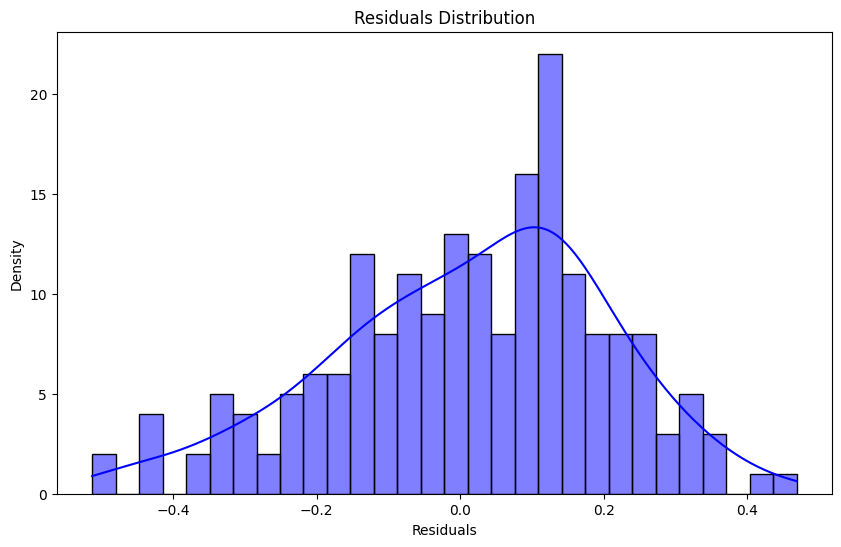

In [9]:
# 6. For the best model, determine the predicted values for the test data and plot
import matplotlib.pyplot as plt
import seaborn as sns

# Pipeline and Transform
best_degree_pipeline = Pipeline([
      ('polynomial', PolynomialFeatures(degree=2, include_bias=False)),])
best_categorical_pipeline = ColumnTransformer([
        ('best_degree', best_degree_pipeline, numerical_columns),
        ("categorical", OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ])

# Fit and Transform
X_train_prepared_best = best_categorical_pipeline.fit_transform(X_train)
X_test_prepared_best = best_categorical_pipeline.transform(X_test)

# Create Model and Predict
best_model = LinearRegression()
best_model.fit(X_train_prepared_best, y_train)
y_pred = best_model.predict(X_test_prepared_best)

# Plot Predicted vs. True Values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('Predicted vs. True Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2)
plt.show()

# Compute Residuals/Errors
residuals = y_test - y_pred

# Create Kernel Density Plot of Residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='blue', bins=30)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()


Having calculated the residuals and plotted them on the chart above, I believe the residuals look roughly bell-shaped around zero. Specifically, the chart is skewed to the right. It appears that the values roughly line up along the diagonal.

Because of this, a weakness is that it predicts the car price slightly off. However, one may argue that this is actually a strength since it predicts the the bare minimum price of the car. Stakeholders will be able to know that this price is the absolute minimum that they need, and they can plan accordingly by saving more money.

An improvement that would be nice is if the chart predicted the absolute maximum, so stakeholderes would be able to save money and know that they will have strong confidence that they have enough since the prediction is an upper bound.

In [10]:
from sklearn.tree import DecisionTreeRegressor

# 7. Use a Regression Tree
depths_to_test = range(1, 21)

best_r2 = -1
best_depth = 0

for depth in depths_to_test:
    tree = DecisionTreeRegressor(max_depth=depth, random_state=42)
    tree.fit(X_train_prepared_best, y_train)

    predictions = tree.predict(X_test_prepared_best)

    r2 = tree.score(X_test_prepared_best, y_test)
    rmse = mean_squared_error(y_test, predictions, squared=False)

    print(f"Depth {depth}: R^2: {r2}, RMSE: {rmse}")

    if r2 > best_r2:
        best_r2 = r2
        best_depth = depth

print(f"\nBest R^2 achieved at depth {best_depth}: {best_r2}")


Depth 1: R^2: 0.3131367847710579, RMSE: 0.359924497075524
Depth 2: R^2: 0.503072232812944, RMSE: 0.306141996168315
Depth 3: R^2: 0.5961711715884888, RMSE: 0.2759783010403925
Depth 4: R^2: 0.6468974438975009, RMSE: 0.25806357417913395
Depth 5: R^2: 0.710424825044201, RMSE: 0.23369904676272543
Depth 6: R^2: 0.731860481080079, RMSE: 0.22488303310353178
Depth 7: R^2: 0.7578375965003077, RMSE: 0.2137123581535194
Depth 8: R^2: 0.7717002048315116, RMSE: 0.20750522567091154
Depth 9: R^2: 0.761565984901623, RMSE: 0.21206079406942044
Depth 10: R^2: 0.7784869934995973, RMSE: 0.20439764752098546
Depth 11: R^2: 0.7980439961311714, RMSE: 0.19516622486814056
Depth 12: R^2: 0.782321914683133, RMSE: 0.20262061612898438
Depth 13: R^2: 0.7715261671056598, RMSE: 0.20758430339765363
Depth 14: R^2: 0.7712020055254062, RMSE: 0.2077315128255558
Depth 15: R^2: 0.7577861858452011, RMSE: 0.21373504232972731
Depth 16: R^2: 0.7578245370760841, RMSE: 0.2137181206556247
Depth 17: R^2: 0.7791308755908452, RMSE: 0.204

As calculated above, the depth that gives the best results is depth 11 with an R^2 of 0.798 and RMSE of 0.195.

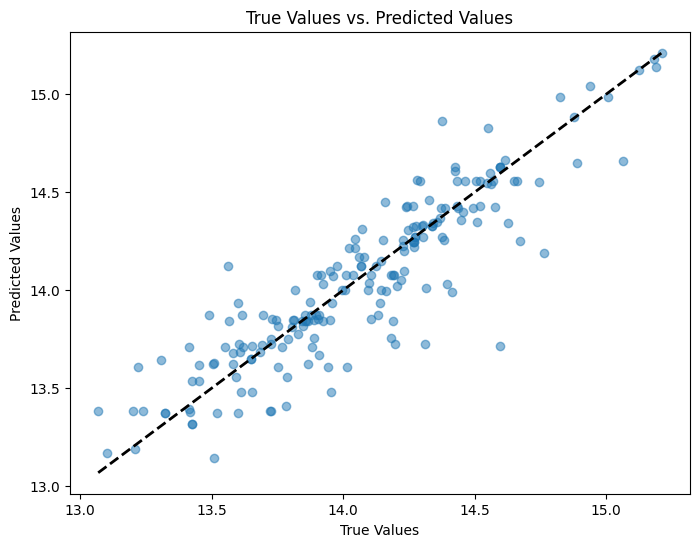

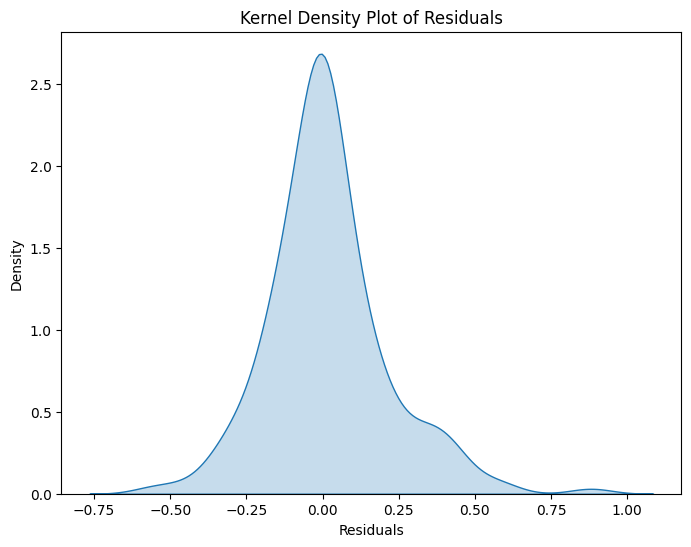

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
# 8. Determine the predicted values for the test data

# Using the best depth obtained
best_tree = DecisionTreeRegressor(max_depth=best_depth, random_state=42)
best_tree.fit(X_train_prepared_best, y_train)

# Predict on the test set using the best tree
best_predictions = best_tree.predict(X_test_prepared_best)

# Plot predicted values vs. true values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, best_predictions, alpha=0.5)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True Values vs. Predicted Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line
plt.show()

# Compute residuals/errors
residuals = y_test - best_predictions

# Create a kernel density plot of residuals
plt.figure(figsize=(8, 6))
sns.kdeplot(residuals, fill=True)
plt.xlabel('Residuals')
plt.title('Kernel Density Plot of Residuals')
plt.show()


According to the chart above, it appears that the predicted values line up along the diagonal. In addition, the residuals chart appears to be roughly bell-shaped around 0.

9. Which model has the better performance on the test set?
* After analyzing my results, it seems that my linear model (with polynomial feature) has a slightly better performance on the test set with an R^2 of 0.804 and an RMSE of 0.192 in comparison to the tree with an R^2 of 0.798 and an RMSE of 0.195.
* Because these results are so close, it seems plausible that the two are very similar and can change which has the better performance based on very minor tuning/settings.

**Q2.** The is a question about regression using decision trees and linear models. The data include wages at data science-y jobs, including

  - `Rating`: Company worker happiness score
  - `Size`: Number of employees
  - `Sector`: Part of the economy
  - `avg_salary`: Average wage
  - `job_state`: Location of work

  1. Load the `wages_hw.csv` file. Split the sample into an ~80% training set and a ~20% test set. Do any necessary cleaning, including outliers and missings.
  2. Use a linear model to regress `avg_salary` on `Sector`. Which sectors have the highest predicted wages? What is the $R^2$ and `RMSE` on the test set?
  3. Make a scatterplot of `avg_salary` and `Rating`. Is there an obvious visual relationship between the two variables? Regress `avg_salary` on `Rating` as a numeric variable: Do higher ratings predict higher or lower wages? Convert `Rating` to a one-hot encoded variable, with a category for each rating. Run a regression of `avg_salary` on the categorical version. How do your results change? Explain. Which version has a higher $R^2$ and lower `RMSE`?
  4. Now interact `Sector` with the categorical version of `Rating`, so your regressors are a (Sector, Rating) pair; this is a programming puzzle you'll have to think about, but using the `.PolynomialFeatures()` function on the one-hot encoded categorical variables is one option, and another is pre-processing a new variable that interacts `Sector` and `Rating` and then one-hot encoding the result. Regress `avg_salary` on the (Sector, Rating) pairs. How does the $R^2$ and `RMSE` on the test set compare to part 2? Interpret the coefficients; which sector-rating pairs have the highest wages?
  5. Run a linear regression of `avg_salary` on all the variables. What is the $R^2$ on the test set? How does it compare to your simpler models in 2--4?
  6. Build a decision tree by regressing `avg_salary` on `Sector`, `Rating`, and the (Sector, Rating) pairs. What are the $R^2$ and `RMSE` of your models on the test set? How do your answers compare to parts 2, 3, and 4?
  7. Build a decision tree by regressing `avg_salary` on all the other variables. What is the $R^2$ and `RMSE` on the test set?
  8. Build a linear regression or decision tree using the available variables based on your own judgment. What degrees of freedom are you giving the model to predict variation in wages across company and location attributes? What is the $R^2$ and `RMSE` of your model? How does it compare to the previous ones in the question? Why does yours perform better or worse on the test set?

**Q3.** This a question purely on categorical prediction. The data for this happen to be gathered in 1987 in Indonesia, and concern contraceptive method choice. The questions and data-gathering assumptions reflect the culture and attitudes of that time and place, but provide a good example of a categorical prediction problem on an important topic (family planning and maternal health The variables in the data are:

    - Wife's age (numerical)
    - Wife's education (categorical) 1=low, 2, 3, 4=high
    - Husband's education (categorical) 1=low, 2, 3, 4=high
    - Number of children ever born (numerical)
    - Wife's religion (binary) 0=Non-Islam, 1=Islam
    - Wife's now working? (binary) 0=Yes, 1=No
    - Husband's occupation (categorical) 1, 2, 3, 4
    - Standard-of-living index (categorical) 1=low, 2, 3, 4=high
    - Media exposure (binary) 0=Good, 1=Not good
    - Contraceptive method used (class attribute) 1=No-use, 2=Long-term, 3=Short-termhort-term

  1. Load the `contraceptiveMethodChoice.csv` data. Tabulate the `method` variable (i.e. `.value_counts()`). 1 corresponds to `No Contraception`, 3 corresponds to `Short Term` (e.g. condoms, birth control pills), and 2 corresponds to `Long Term` (e.g. IUD, sterilization). Cross tabulate `method` and `numberChildren`. Do couples that use birth control tend to have more children than those who don't?
  2. Split the sample into ~80% training data and ~20% testing data.
  3. We are now going to make a mistake. Train a regression tree to predict the contraceptive method using the other variables in the data, not a classification tree. Look at the terminal nodes in the tree: What values do they take? Does that make sense? Explain clearly what has gone wrong here.
  4. Instead of regression, use a classification tree to predict contraceptive method using the other variables in the data. How does it look different from the previous tree? What variables does the algorithm use? In broad terms, which groups of people are most likely to use each method of contraception?
  5. Compute a confusion matrix for your classification tree on the test set (Hint: There are now three categories instead of two, so the cross tabulation will be a $3 \times 3$ matrix instead of $2 \times 2$.). Compute the Accuracy of your model overall, and the Accuracy for predicting each contraceptive method.
  7. Why can't you use a linear probability model to do this exercise? Explain clearly in words.

In [12]:
# 1. Load data, tabulate variables.
import pandas as pd
df2 = pd.read_csv('./assignment4/data/contraception_hw.csv')

# Cleaning: Drop the unecessary column # At first I dropped this column, however it produced inaccurate results. When I left it in, the accuracy increased.
# df2 = df2.drop('Unnamed: 0', axis=1)

# Tabulate the method variable
method_distribution = df2['method'].value_counts()
print("Method Distribution:")
print(method_distribution)
print()

# Cross-tabulate method and numberChildren
method_children_cross_tab = pd.crosstab(df2['method'], df2['numberChildren'])
print("Cross-tabulation of method and numberChildren:")
print(method_children_cross_tab)
print()

# Analyze if couples using birth control tend to have more children than those who don't
no_contraception = method_children_cross_tab.loc[1].sum()
short_term_contraception = method_children_cross_tab.loc[3].sum()

print("Total number of children for 'No Contraception':", no_contraception)
print("Total number of children for 'Short Term Contraception':", short_term_contraception)
print()

# Calculate average number of children for each group
average_children_no_contraception = method_children_cross_tab.loc[1].mean()
average_children_short_term = method_children_cross_tab.loc[3].mean()

print("Average number of children for 'No Contraception':", average_children_no_contraception)
print("Average number of children for 'Short Term Contraception':", average_children_short_term)
print()

# Compare the averages
if average_children_short_term > average_children_no_contraception:
    print("Couples using short-term contraception tend to have more children than those not using contraception.")
else:
    print("There doesn't seem to be a clear trend indicating that couples using birth control have more children.")


Method Distribution:
1    629
3    511
2    333
Name: method, dtype: int64

Cross-tabulation of method and numberChildren:
numberChildren  0    1    2    3   4   5   6   7   8   9   10  11  12  13  16
method                                                                       
1               95  143  114   70  57  44  35  18  29   5   9   6   4   0   0
2                0   46   56   70  62  36  27  19   9   3   2   2   0   1   0
3                2   87  106  119  78  55  30  12   9   8   0   3   0   1   1

Total number of children for 'No Contraception': 629
Total number of children for 'Short Term Contraception': 511

Average number of children for 'No Contraception': 41.93333333333333
Average number of children for 'Short Term Contraception': 34.06666666666667

There doesn't seem to be a clear trend indicating that couples using birth control have more children.


After tabulating method and method vs numberChildren, some interesting statistics are found. Specifically, the total number of children of couples using contraceptives is less than couples that don't use contraceptives. The same result is found in the average number of children where couples that use contraceptives have less children on average.

Because of these findings, there doesn't seem to be a trend that indicates that couples using birth control have more children. In fact, it seems to indicate the opposite, although more analysis is needed to be conducted to confirm this trend.

In [13]:
# 2. Split the sample into ~80% training data and ~20% testing data.

# Features and target variable
X = df2.drop('method', axis=1)
y = df2['method']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Values in terminal nodes:
 [1.93039049 1.         2.29704142 2.62121212 2.         3.
 1.90600522 1.         2.59907834 2.         3.        ]


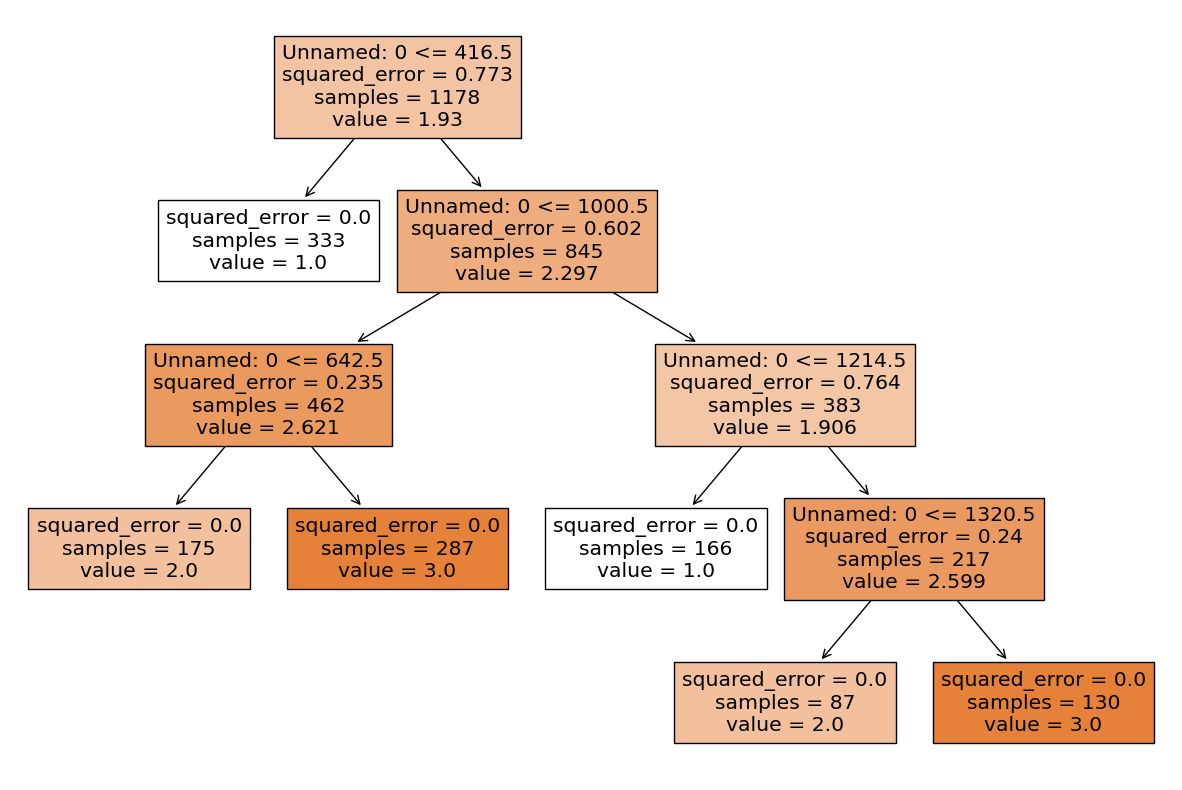

In [14]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
# 3. Make a mistake.
# Train a regression tree to predict the contraceptive method using the other variables in the data, not a classification tree.

regressor = DecisionTreeRegressor(random_state=42)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)


# Look at the terminal nodes in the tree: What values do they take? Does that make sense? Explain clearly what has gone wrong here.
terminal_nodes = regressor.tree_.value.squeeze()
print("Values in terminal nodes:\n", terminal_nodes)


# Visualize the mistaken regression tree
plt.figure(figsize=(15, 10))
plot_tree(regressor, filled=True, feature_names=X.columns, class_names=['No-use', 'Long-term', 'Short-term'])
plt.show()

The terminal nodes here should be predicting the contraceptive method for the corresponding samples in the test set. Instead, the terminal nodes are producing decimals, which doesn't make sense. It doesn't make sense because the contraceptive methods are categorical and should be represented by classes. In addition, you can see that the parents of the terminal nodes have an uneven decimal, which also doesn't make sense. It is not possible to have a contraceptive inbetween two classes since it one or the other (not both).

This mistake here is that a regression tree is being used for a classification problem. Regression trees should be used for predicting numerical/continuous values. That is why the predicted output here is a decimal (decimals are continuous values). The correct way to approach this is to use a classification tree in order to predict categorical outcomes.

Values in terminal nodes (Classification Tree):
[[499. 262. 417.]
 [333.   0.   0.]
 [166. 262. 417.]
 [  0. 175.   0.]
 [166.  87. 417.]
 [  0.   0. 287.]
 [166.  87. 130.]
 [166.   0.   0.]
 [  0.  87. 130.]
 [  0.  87.   0.]
 [  0.   0. 130.]]


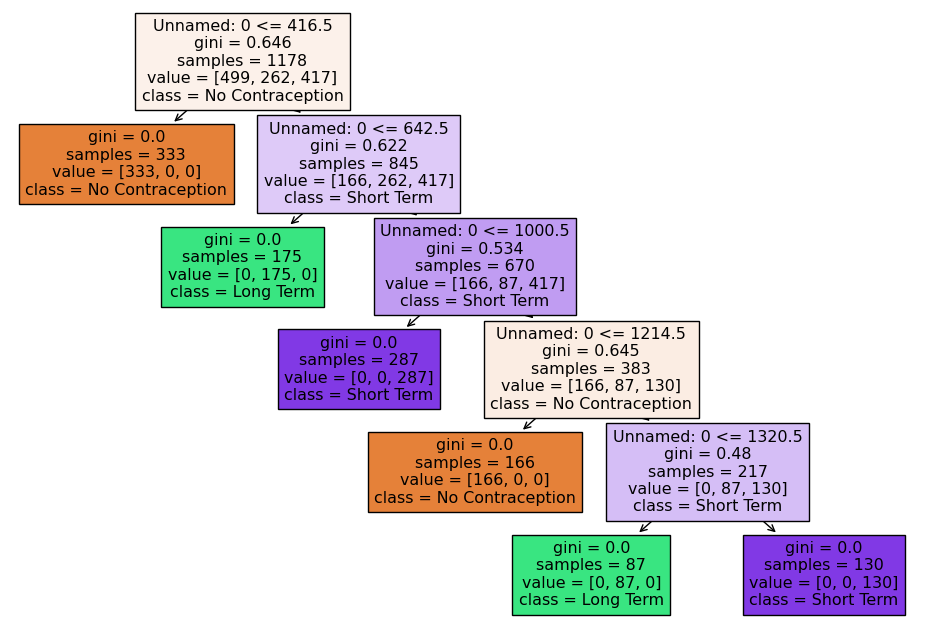

In [15]:
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
import matplotlib.pyplot as plt
from sklearn import tree

# 4. Use a classification tree
classifier = DecisionTreeClassifier(random_state=42)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

# Get the values in terminal nodes
terminal_nodes_classifier = classifier.tree_.value.squeeze()
print("Values in terminal nodes (Classification Tree):")
print(terminal_nodes_classifier)

# Visualize the classification tree
plt.figure(figsize=(12, 8))
plot_tree(classifier, filled=True, feature_names=X.columns, class_names=['No Contraception', 'Long Term', 'Short Term'])
plt.show()


The output looks different from the previous tree because the terminal nodes are categorical (from a classification tree) whereas the previous tree were continuous (from a regression tree). In the output, the first row corresponds to the first terminal node where 499 samples predicted as "No Contraception" (class 1), 262 samples predicted as "Long Term" (class 2), and 417 samples predicted as "Short Term" (class 3).

After reviewing the tree structure, it seems that the algorithm is using the variables age, edu, edu_spouse, numberChidlren, religion, working, spouse_occupation, standardOfLivingIndex, and mediaExposure. Based on the first few nodes of the tree (in broad terms), it seems like groups that have less than 0.5 children and that are less than 17.5 years old are most likely to use short term contraceptives. Groups that have more than 0.5 children and are less than 37.5 years old are likely to use no contraceptives. Groups that have more than 0.5 children, greater than 37.5 years old, and an education rating greater than 3.5 are likely to use long term contraceptives. Note that these are generalizations based on a few nodes and that more comprehensive categorizations are possible with more research.


In [16]:
# 5. Compute the confusion matrix and accuracy of the model

# Compute the confusion matrix and save the variable
conf_matrix = pd.crosstab(y_test, y_pred)

# Compute overall accuracy without using accuracy_score
overall_accuracy = (conf_matrix.iloc[0,0] + conf_matrix.iloc[1,1] + conf_matrix.iloc[2,2]) / conf_matrix.sum().sum()
print("\nOverall Accuracy:", overall_accuracy)

# Compute accuracy for each class
method_accuracy = {}
for i in range(3):
    method = 'Contraceptive Method ' + str(i+1)
    accuracy = conf_matrix.iloc[i, i] / conf_matrix.iloc[i, :].sum()
    method_accuracy[method] = accuracy

print("\nAccuracy for predicting each contraceptive method:")
for method, accuracy in method_accuracy.items():
    print(f"{method}: {accuracy}")

# Print the confusion matrix
print("\nConfusion Matrix:")
pd.crosstab(y_test, y_pred)


Overall Accuracy: 0.9966101694915255

Accuracy for predicting each contraceptive method:
Contraceptive Method 1: 1.0
Contraceptive Method 2: 0.9859154929577465
Contraceptive Method 3: 1.0

Confusion Matrix:


col_0,1,2,3
method,,,
1,130,0,0
2,1,70,0
3,0,0,94


### 6. Why can't you use a linear probability model to do this exercise? Explain clearly in words.

Linear probability models are models used to estimate the probability of a binary outcome. It should not be used for this exercise because the result of linear probability models may be a probability outside of the range 0% to 100%. This is invalid for this problem because you cannot over-guarantee a certain type of a contraceptive method and likewise you cannot have a negative probability of a contraceptive method. Although the data was cleaned to remove outliers, another reason why linear probability models shouldn't be used is because they are very sensitive to outliers which can affect the estimates.

Rather than using this model, it's best to use the models analyzed above in this report.

**Q4.** This is a question where we use regression and regression trees. The outcome is whether a defendant is held pre-trial in the Virginia justice system. We would like to understand how that outcome is predicted by characteristics of the defendant, particularly race. Let's be very careful/clear: We aren't saying anyone *should* be held without bond or asserting that people with different demographic variables *should* be more likely to be held, but instead trying to predict whether people with different characteristics *are empirically more likely* to be held without bond, given the available information. This is the first step we would take in investigating whether a system is fair, or how large the disparities are: Does it treat people with similar observable characteristics similarly, or not? We are going to look at a common question: Are Black defendants treated differently from white or Asian ones? (There are Native American defendants, but there are 11 in total, which is such a small number of observations that is difficult to clearly say anything about how this group is treated relative to the others.)

The variables in the data are:

  - `held_wo_bail`: Whether a defendant is held without bail before trial (Boolean logical)
  - `race`, `sex`: Categorical demographic variables
  - `is_poor`: Whether the defendant is classified as indigent
  - `prior_F`, `prior_M`: The number of prior felony and misdemeanor arrests
  - `case_type`: A categorical variable indicating a misdemeanor `M` or felony `F` or infraction `I` or special case `S`
  - `age`: Defendant's age
  - `bond`, `bond_NA`, `bond_type`: The amount of any bond, whether it is missing, and the type
  - `sentence`, `sentence_NA`, `sentence_type`: The length of any sentence, whether it is missing, and the type

1. Load the `pretrial_data.csv` data. Notice that there are `nan`s, but the data are relatively clean. Because there are `.nan`s among variables you won't use, you'll want to narrow down your analysis to the relevant variables before dropping or imputing missing values.
2. Create a dummy variable indicating that the defendant is Black.
3. Regress `held` on `Black`. What is the slope coefficient Interpret the coefficient on the Black dummy variable: How much more likely is a black person to be held without bail? What is the $R^2$ of the model?
4. Before doing this question, please think for a few minutes about how to make the process of running these regressions as efficient as possible, before jumping into writing code. Repeat part 2, for the following specifications, keeping track of the coefficient on the Black dummy variable each time:
      - `held` on `Black` and `sex`
      - `held` on `Black` and `sex` and `is_poor`
      - `held` on `Black` and `sex` and `is_poor` and `prior_F`
      - `held` on `Black` and `sex` and `is_poor` and `prior_F` and `case_type`
What happens to the coefficient on the Black dummy variable as you include more regressors/features/controls in the regression? Explain your findings.
5. Suppose we don't want to see just `Black` and `sex`, but `Black` interacted with `sex`: Are Black men and Black women treated systemically differently from the rest of the population? Implement this in a regression, and explain your findings.
6. Imagine someone argued we should use these kinds of models to help a judge or magistrate make bail decisions (you could obviously go back and make this kind of model for the bond and sentence variables, then deploy it on new cases to predict what their bond and sentence values would be). What concerns would you have? Do you think society should be using data-driven and automated tools like that? Explain your concerns clearly.

**Q5.** This is a math question to review the derivation of the OLS estimator (but only if you are into that kind of thing!). We are going to do it slightly differently from what we did in class, though. We will use a linear predictor and minimize the Sum of Squared Errors, just as in class. But, we are going to de-mean $X$ first, creating another variable $z_i = x_i - \bar{x}$ where
$$
\bar{x} = \dfrac{1}{N} \sum_{i=1}^N x_i,
$$
so the model is $\hat{y}_i = a + b z_i$ and the `SSE` is
$$
\text{SSE}(a,b) = \sum_{i=1}^N (y_i - a - bz_i)^2.
$$

  1. Take partial derivatives of the `SSE` with respect to $a$ and $b$. You should get

\begin{eqnarray*}
\sum_{i=1}^N -2(y_i - a- bz_i) &=& 0 \\
\sum_{i=1}^N -2(y_i - a - bz_i)z_i &=& 0.
\end{eqnarray*}

  2. Solve for the solutions to the above equations. Big hint: $\bar{z} = 0$, since we subtracted the mean of $x$ from $x$ to get $z$. You should get

\begin{eqnarray*}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\sum_{i=1}^N(y_i - \bar{y})z_i}{\sum_{i=1}^N z_i^2}.
\end{eqnarray*}

  3. Substitute $z_i = x_i - \bar{x}$ back into the above equations. You should get
  
\begin{eqnarray*}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\sum_{i=1}^N(y_i - \bar{y})(x_i-\bar{x})}{\sum_{i=1}^N (x_i-\bar{x})^2},
\end{eqnarray*}

which can be written in terms of sample covariance and sample variance as:

\begin{eqnarray*}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\text{cov}(x,y)}{\text{var}(x)}.
\end{eqnarray*}

This is typically the preferred way of expressing the OLS coefficients.

4. When will $b^*$ be large or small, depending on the relationship between $x$ and $y$ and the amount of "noise"/variance in $x$? What does $a^*$ represent?
5. Suppose you have measurement error in $x$ which artificially inflates its variance (e.g. bad data cleaning). What happens to the $b^*$ coefficient? How will affect your ability to predict? (This phenomenon is called **attenuation**.)
6. Let's return to the question of *outliers*. With your formula for the OLS coefficients $(a^*,b^*)$, explain what happens if you significantly increase a single value of the outcome/target/response variable $y_i$ or one of the predictor/explanatory/covariate variables $x_i$. If values for some extreme observations are exerting significant influence over the regression coefficients, will the model perform well on for more average observations?